# Method Comparison
The following contains a simple method comparison for the introductory blog post on blog.inovex.de. It uses the synthetic dataset designed in my thesis to show the strengths and weaknesses of single learners. 

In [1]:
# Standard imports and plot settings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn")
plt.rcParams["axes.labelsize"] = 10
plt.rcParams["figure.facecolor"] = "1"
plt.rcParams["grid.color"] = "black"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["figure.figsize"] = (10,10)


sns.set_style("whitegrid")
sns.set_context("poster")


CYAN = "#4ECDC4"
BLUE = "#59D2FE"
RED = "#FF6B6B"
YELLOW = "#FAA916"
GREY = "#4A6670"

## The Two Settings

### Multi-Modal
First, we generate the synthetic data described as multi-modal setting (or just MULTI) based on the IHDP covariates. In *JustCause*, this DGP is already implemented, as it was part of my thesis evaluation and neatly shows the core statement: changing the data generating process changes the results immensely. 

We can simply load the desired number of replications using the provided endpoint. We choose 100, in order to flat out sample irregularities which come from the Bernoulli and normal distributions in the below definitions. For the standard IHDP reference data, usually 1000 replications are chosen. The multi-modal setting is defined as: 

$$y_0 = \mathcal{N}(0, 0.2) \\ y_1 = y_0 + \tau \\ t = \text{BERN}[sigmoid(X_8)]$$

with $\tau$ being: 

$$        \gamma = \mathbb{I}(sigmoid(X_8) > 0.5) \\         \tau = \mathcal{N}(3*\gamma + (1 - \gamma), 0.1)$$

That is to say, there are two groups in the population. One that responds strongly to treatment $(\tau \cong 3)$, and one that doesn't respond as much ($\tau \cong 1$). And the two are split discretely. 

### Exponential 
The other setting, called EXPO, is defined exactly the same way as MULTI, but with the different $\tau$. 

$$ \tau = exp(1 + sigmoid(X_8)) $$

In words this means, there are no two distinct groups but rather a wide range of possible treatment effects among the population. We can see these intuitions visually in the plot below

Text(0.5,1,'MULTI setting')

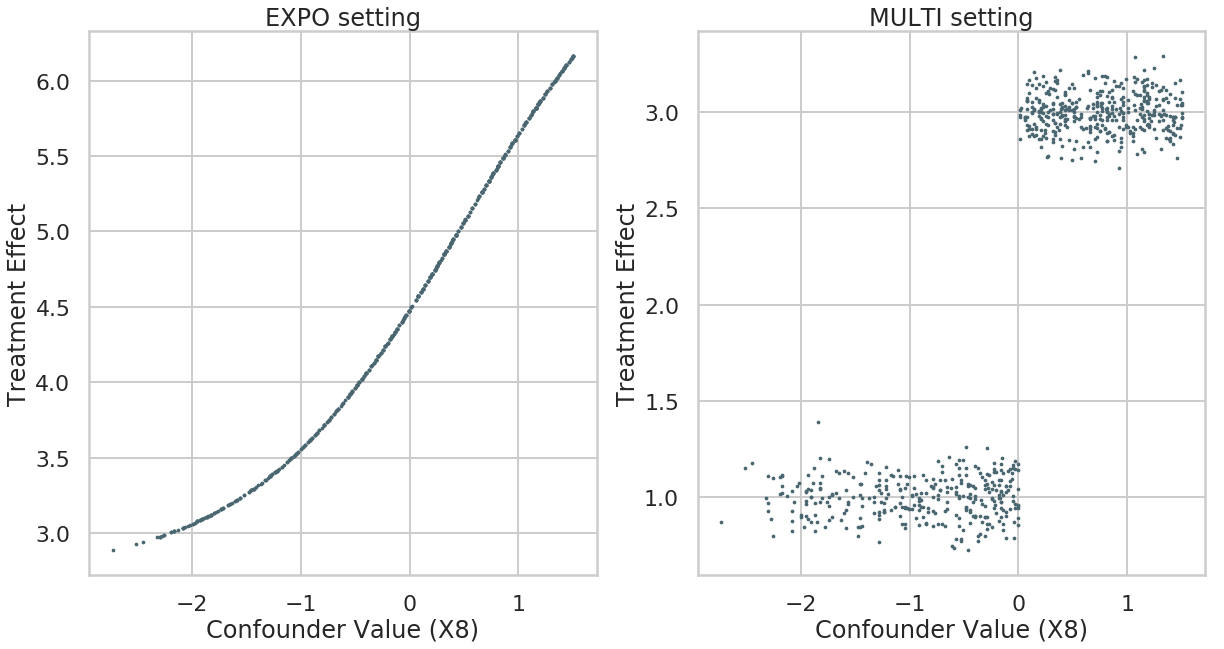

In [2]:
from justcause.data.generators import multi_expo_on_ihdp

# Load a list of 100 replications
multi = multi_expo_on_ihdp(setting='multi-modal', n_replications=100)
expo = multi_expo_on_ihdp(setting='exponential', n_replications=100)

# Look at one replication
rep_exp = expo[0]
rep = multi[0]

fg, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.scatter(rep_exp.np.X[:, 0], rep_exp.np.ite, s=3, color=GREY)
ax2.scatter(rep.np.X[:, 0], rep.np.ite, s=3, color=GREY)
ax1.set_xlabel('Confounder Value (X8)')
ax1.set_ylabel('Treatment Effect')
ax2.set_xlabel('Confounder Value (X8)')
ax2.set_ylabel('Treatment Effect')
ax1.set_title('EXPO setting')
ax2.set_title('MULTI setting')

## Evaluation of Learners
We first setup the learners we want to evaluate using _JustCause_. We then use the standard implementation of an individual treatment effect evaluation implemented in the `evaluate_ite` method. 

In [3]:
from justcause.learners.utils import install_r_packages
from justcause.learners import SLearner, TLearner, CausalForest, RLearner, XLearner

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


# Ensure 'grf' R package is installed in the environment
install_r_packages(['grf'])

learners = [
    SLearner(LinearRegression()), 
    TLearner(LinearRegression()), 
    XLearner(LinearRegression()), 
    SLearner(RandomForestRegressor()), 
    TLearner(RandomForestRegressor()), 
    XLearner(RandomForestRegressor()), 
    CausalForest()]

/home/mfranz/miniconda/envs/justcause/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/mfranz/miniconda/envs/justcause/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
/home/mfranz/miniconda/envs/justcause/lib/python3.7/site-packages/tensorflow/python/fr

In [4]:
from justcause.evaluation import evaluate_ite
from justcause.metrics import pehe_score, mean_absolute, bias

results = evaluate_ite(multi, learners, metrics=[pehe_score, mean_absolute, bias], random_state=0)

In [5]:
# Reordering columns for readability 
df = pd.DataFrame(results).sort_values('pehe_score-mean')
df[df['train'] == False][['method', 'train', 'pehe_score-mean']]

,method,train,pehe_score-mean
13,CausalForest,False,0.136886
11,"XLearner(outcome_c=RandomForestRegressor, outc...",False,0.168023
7,SLearner(learner=RandomForestRegressor),False,0.169896
9,"TLearner(control=RandomForestRegressor, treate...",False,0.170758
5,"XLearner(outcome_c=LinearRegression, outcome_t...",False,0.574248
3,"TLearner(control=LinearRegression, treated=Lin...",False,0.574248
1,SLearner(learner=LinearRegression),False,0.993209


### Understanding the results
What we see above is that the Causal Forest performs best on the Multi-Modal setting, which is the expected result. After all, it is the definition of the Causal Forest to split the population into groups with equal or similar treatment effects. The multi-modal setting is exactly that. 
Linear learners (T- or S-Learner with LinearRegression) on the other hand, have a hard time estimating the discrete groups. The same learners fare much better with RandomForestRegressors as base learners, because these are more flexible in their estimation. In other words, RandomForest don't impose a modelling assumption and are thus better suited to tackle unknown distributions. 

## Exponential Setting
The second evaluation is based on a slightly different DGP, which does not contain the two distinct treatment groups.

In [6]:
results = evaluate_ite(expo, learners, metrics=[pehe_score, mean_absolute, bias], random_state=0)

df = pd.DataFrame(results).sort_values('pehe_score-mean')
df[df['train'] == False][['method', 'train', 'pehe_score-mean']]

divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in greater_equal
divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in greater_equal


,method,train,pehe_score-mean
11,"XLearner(outcome_c=RandomForestRegressor, outc...",False,0.104642
9,"TLearner(control=RandomForestRegressor, treate...",False,0.115867
7,SLearner(learner=RandomForestRegressor),False,0.116241
3,"TLearner(control=LinearRegression, treated=Lin...",False,0.167952
5,"XLearner(outcome_c=LinearRegression, outcome_t...",False,0.167952
13,CausalForest,False,0.222055
1,SLearner(learner=LinearRegression),False,0.949983


### Understanding the results
For the exponential setting, the results are quite different. This goes back to the fact that treatment effects follow a largely different distribution. In the new case, The X- and T-Learner with RandomForests fare best and even the T-Learner with linear regression performs better than the previous champion, CausalForest. 

We can argue why this is the case, but this exceeds the scope of this notebook and the corresponding plot. Read up on the results in more detail in Chapter 5.3 of [my thesis](https://justcause.readthedocs.io/en/latest/_downloads/e054f7a0fc9cf9e680173600cb4b4350/thesis-mfranz.pdf). 